# Simulating Clifford randomized benchmarking using a generic noise model

This tutorial demonstrates shows how to simulate Clifford RB sequences using arbitrary $n$-qubit process matrices.  In this example $n=2$.

In [1]:
import pygsti
import numpy as np

## Get some CRB circuits

First, we follow the [Clifford RB](../CliffordRB.ipynb) tutorial to generate a set of sequences.  If you want to perform Direct RB instead, just replace this cell with the contents of the [Direct RB](../DirectRB.ipynb) tutorial up until the point where it creates `circuitlist`:

In [2]:
#Specify the device to be benchmarked - in this case 2 qubits
nQubits = 2
qubit_labels = [0,1] 
gate_names = ['Gxpi2', 'Gypi2','Gcphase'] 
availability = {'Gcphase':[(0,1)]}
pspec = pygsti.obj.ProcessorSpec(nQubits, gate_names, availability=availability, 
                                 qubit_labels=qubit_labels)

#Specify RB parameters (k = number of repetitions at each length)
lengths = [0,1,2,4,8,16]
k = 10
subsetQs = [0,1]
randomizeout = False # ==> all circuits have the *same* ideal outcome (the all-zeros bitstring)

#Generate clifford RB circuits
exp_design = pygsti.protocols.CliffordRBDesign(pspec, lengths, k, qubit_labels=subsetQs, randomizeout=randomizeout)

#Collect all the circuits into one list:
circuitlist = exp_design.all_circuits_needing_data

- Sampling 10 circuits at CRB length 0 (1 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 1 (2 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 2 (3 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 4 (4 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 8 (5 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 16 (6 of 6 depths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,


## Create a model to simulate these circuits
Now we need to create a model that can simulate circuits like this.  Two things to note:

1. RB circuits use our "multi-qubit" gate naming, so you have gates like `Gxpi2:0` and `Gcphase:0:1`.
2. RB circuits do gates in parallel (this only matters for >1 qubits), so you have layers like `[Gypi2:0Gypi2:1]`

In this example, we'll make a model with $n$-qubit process matrices, so this will be practically limited to small $n$.  We construct a model based on our standard 2-qubit X, Y, and CPHASE model, since this 
has all the appropriate gates.  To get a model with the multi-qubit labels, we'll use a standard multi-qubit "model-pack", which packages a `Model` object with relevant meta information needed by other protocols (like GST).  If you can't start with a standard model, then you'll need to create an `ExplicitOpModel` object of the appropriate dimension (see the [explicit models tutorial](../../objects/ExplicitModel.ipynb)) and assign to it gates with are, for instance `('Gxpi2',0)` rather than just `'Gxpi2'`.

Here we import the `smq2Q_XYCPHASE` model pack:

In [3]:
from pygsti.modelpacks import smq2Q_XYCPHASE

We'll depolarize the target model and set one of the process matrices to a custom value as a demonstration.  Here is where you can set any 2-qubit process matrices you want to any of the gates:

In [4]:
myModel = smq2Q_XYCPHASE.target_model().depolarize(op_noise=0.01, spam_noise=0.01)
myModel[('Gx',0)] = np.kron( 
    np.array([[1, 0, 0, 0],
              [0, 0.85, 0, 0],
              [0, 0, 0, -0.85],
              [0, 0, 0.85, 0]], 'd'),
    np.array([[1, 0, 0, 0],
              [0, 0.95, 0, 0],
              [0, 0, 0.95, 0],
              [0, 0, 0, 0.95]], 'd'))
#print(myModel[('Gx',0)])
myModel.operations.keys() #voila! you have gates like "Gx:0" rather than "Gxi"

odict_keys([Label[Gxpi2:1], Label[Gypi2:1], Label[Gxpi2:0], Label[Gypi2:0], Label[Gcphase:0:1], Label[Gx:0]])

Since, `ExplicitOpModel` objects (e.g., those in the model packs) don't know how to automatically simulate multiple gates in parallel (you'd need to add an operation for each layer explicitly), we'll just *serialize* the circuits so they don't contain any parallel gates.  This addresses point 2) above.  Then we can simulate our circuits using our `ExplicitOpModel`, creating a `DataSet`.

In [5]:
serial_circuits = [c.serialize() for c in circuitlist]
ds = pygsti.construction.generate_fake_data(myModel, serial_circuits, 100, seed=1234)

#See how the DataSet contains serialized circuits (just printing the first several layers for clarity)
print(ds.keys()[10][0:7])
print(circuitlist[10][0:5])

Qubit 0 ---|     |-|Gxpi2|-|Gypi2|-|     |-|C1|-|     |-|Gypi2|---
Qubit 1 ---|Gxpi2|-|     |-|     |-|Gypi2|-|C0|-|Gypi2|-|     |---

Qubit 0 ---|Gxpi2|-|Gypi2|-|C1|-|Gypi2|-|C1|---
Qubit 1 ---|Gxpi2|-|Gypi2|-|C0|-|Gypi2|-|C0|---



Next, we "un-serialize" the circuits in the resulting data-set (`ds`) using the `process_circuits` function.  This is needed because the RB experiment design calls for the original (parallel-gate) circuits, not the serialized ones.  The cell below updates the circuits for all the data we just simulated so the data counts are associated with the original circuits.

In [6]:
#map circuits in dataset back to non-serialized RB circuits that we expect to have data for:
unserialize_map = { serial_circuit: orig_circuit for (serial_circuit, orig_circuit) in zip(serial_circuits, circuitlist)}
ds = ds.copy_nonstatic()
ds.process_circuits(lambda c: unserialize_map[c])
ds.done_adding_data()

## Running RB on the simulated `DataSet`
To run an RB analysis, we just package up the experiment design and data set into a `ProtocolData` object and give this to a `RB` protocol's `run` method.  This returns a `RandomizedBenchmarkingResults` object that can be used to plot the RB decay curve.  (See the [RB analysis tutorial](../RBAnalysis.ipynb) for more details.)

In [7]:
data = pygsti.protocols.ProtocolData(exp_design, ds)
results = pygsti.protocols.RB().run(data)

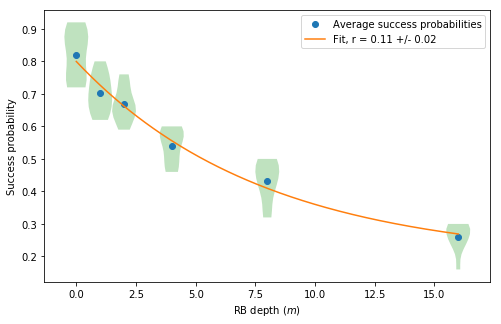

In [8]:
%matplotlib inline
results.plot()